In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

In [2]:
import sys
sys.path.append("/g/g92/dskoda/prj/dskrc/python/inits")

from plotting import *
plt.rcParams['figure.dpi'] = 150
plt.style.use("paper")

In [3]:
hpr = pd.read_csv("02_data/mace_hyperparams.csv", index_col=0)
lcv = pd.read_csv("02_data/mace_learning.csv", index_col=0)
lls = pd.read_csv("02_data/mace_losslands.csv", index_col=0)
sdf = pd.read_csv("02_data/mace_entropy.csv", index_col=0)
exp = pd.read_csv("02_data/mace_explosion.csv", index_col=0)
ext = pd.read_csv("02_data/mace_extrapolation_errors.csv", index_col=0)

In [4]:
LABELS = {
    "no_rescaling": "v=2, L=3, no rescaling",
    "no_bessel": "v=2, L=3, all opt",
    "only_rescaling": "v=2, L=3, rescaling",
    "rescaling+bessel": "v=2, L=3, Bessel",
    "v2-base": "v=2, L=3, baseline",
    "v2-amsgrad": "v=2, L=3, AMSGrad",
    "v2-ema": "v=2, L=3, EMA",
    "v2-swa": "v=2, L=3, SWA",
    "v3_l3": "v=3, L=3",
    "v2_l3": "v=2, L=3",
    "v1_l3": "v=1, L=3",
    "v2_l2": "v=2, L=2",
    "v2_l1": "v=2, L=1",
    "v2_l0": "v=2, L=0",
    "v1_l0": "v=1, L=0",
}
FIGS_DIR = "03_figs"

In [5]:
MODELS = {
    "BIG": ["no_rescaling", "no_bessel", "only_rescaling", "rescaling+bessel"],
    "OPT":  ["v2-base", "v2-swa", "v2-ema", "v2-amsgrad"],
    "V1": ["v1_l0", "v1_l3"],
    "V2": ["v2_l0", "v2_l1", "v2_l2", "v2_l3"] ,
    "VL3": ["v1_l3", "v2_l3", "v3_l3"],
}

MODELS_ORDER = MODELS["BIG"] + MODELS["OPT"] + MODELS["V1"] + MODELS["V2"] + MODELS["VL3"]
MODELS_L3 = MODELS["BIG"] + MODELS["OPT"] + MODELS["VL3"]

In [6]:
CMAPS = {
    "BIG": cm.Reds_r,
    "OPT": cm.Blues_r,
    "V1": cm.Greys_r,
    "V2": cm.Greens_r,
    "VL3": cm.Purples_r,
}

In [7]:
labels = pd.DataFrame(LABELS.values(), index=LABELS.keys(), columns=["label"])

In [8]:
_colors = {}
for mset, cases in MODELS.items():
    norm = plt.Normalize(0, len(cases))
    for i, name in enumerate(cases):
        _colors[name] = CMAPS[mset](norm(i))
    
labels["color"] = pd.Series(_colors)

In [9]:
hpr[[
    "correlation",
    "max_ell",
    "hidden_irreps",
    "E0s",
    "num_interactions",
    "trainable_bessel",
    "swa",
    "ema",
    "amsgrad",
]].fillna(False)

,correlation,max_ell,hidden_irreps,E0s,num_interactions,trainable_bessel,swa,ema,amsgrad
no_rescaling,2,3,256x0e + 256x1o + 256x2e,"{1:0.0,6:0.0,7:0.0,8:0.0}",2,True,True,True,True
no_bessel,2,3,256x0e + 256x1o + 256x2e,average,2,False,True,True,True
only_rescaling,2,3,256x0e + 256x1o + 256x2e,average,2,False,False,False,False
rescaling+bessel,2,3,256x0e + 256x1o + 256x2e,average,2,True,True,True,True
v1_l0,1,0,256x0e,average,2,False,True,True,True
v1_l3,1,3,256x0e + 256x1o + 256x2e,average,2,False,True,True,True
v2_l0,2,0,256x0e,average,2,False,True,True,True
v2_l1,2,1,256x0e + 256x1o,average,2,False,True,True,True
v2_l2,2,2,256x0e + 256x1o + 256x2e,average,2,False,True,True,True
v2_l3,2,3,256x0e + 256x1o + 256x2e,average,2,False,True,True,True


In [10]:
def sort_df_by_category(df, key, sorter):
    df = df.copy()
    df["cat"] = df[key].astype("category")
    df["cat"] = df["cat"].cat.set_categories(sorter)
    df = df.sort_values(["cat"]).drop("cat", axis=1)
    
    return df

## Explosion times

webf NOT subset; don't know how to subset; dropped


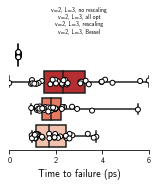

webf NOT subset; don't know how to subset; dropped


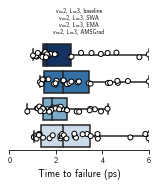

webf NOT subset; don't know how to subset; dropped


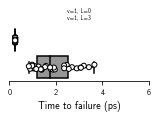

webf NOT subset; don't know how to subset; dropped


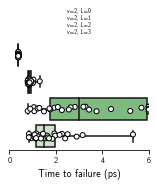

webf NOT subset; don't know how to subset; dropped


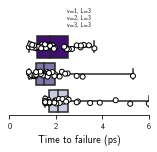

In [11]:
for name, grp in MODELS.items():
    _df = exp.loc[exp.model.isin(grp)].sort_values("model")
    _df["explosion"] = _df["explosion"] / 1000
    _df = sort_df_by_category(_df, "model", grp)
    
    norm = plt.Normalize(0, len(grp))
    palette = [CMAPS[name](norm(i)) for i in range(len(grp))]
    
    rows = len(grp) / 4
    fig, ax = plt.subplots(figsize=(2.5, 2 * rows))

    sns.boxplot(
        data=_df,
        x="explosion",
        y="model",
        ax=ax,     
        palette=palette,
        whis=(0, 100),
    )

    sns.stripplot(
        data=_df,
        x="explosion",
        y="model",
#         alpha=0.75,
        ax=ax,
        color="w",
        size=5,
        edgecolor="k",
        linewidth=1
    )

    ax.set_xlabel("Time to failure (ps)")
    ax.set_ylabel("")
    ax.spines["left"].set_visible(False)
    ax.set_xlim(0, 6)
    
    _labels = "\n".join(labels.loc[grp]["label"].values)
    ax.set_title(_labels, fontsize="xx-small")
    ax.set_yticks([])
    
#     fig.tight_layout()
    fig.savefig(f"{FIGS_DIR}/mace_explosion_{name}.pdf", bbox_inches="tight", transparent=True)
    plt.show()

webf NOT subset; don't know how to subset; dropped


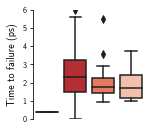

webf NOT subset; don't know how to subset; dropped


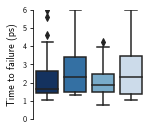

webf NOT subset; don't know how to subset; dropped


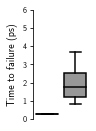

webf NOT subset; don't know how to subset; dropped


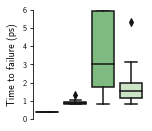

webf NOT subset; don't know how to subset; dropped


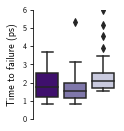

In [13]:
for name, grp in MODELS.items():
    _df = exp.loc[exp.model.isin(grp)].sort_values("model")
    _df["explosion"] = _df["explosion"] / 1000
    _df = sort_df_by_category(_df, "model", grp)
    
    norm = plt.Normalize(0, len(grp))
    palette = [CMAPS[name](norm(i)) for i in range(len(grp))]
    
    rows = len(grp) / 4
    fig, ax = plt.subplots(figsize=(2 * rows, 2))

    sns.boxplot(
        data=_df,
        x="model",
        y="explosion",
        ax=ax,     
        palette=palette,
#         whis=(0, 100),
    )

#     sns.stripplot(
#         data=_df,
#         x="explosion",
#         y="model",
# #         alpha=0.75,
#         ax=ax,
#         color="w",
#         size=5,
#         edgecolor="k",
#         linewidth=1
#     )

    ax.set_ylabel("Time to failure (ps)")
    ax.set_xlabel("")
    ax.spines["bottom"].set_visible(False)
    ax.set_ylim(0, 6)
    
    _labels = "\n".join(grp)
#     ax.set_title(_labels, fontsize="xx-small")
    ax.set_xticks([])
    
    fig.savefig(f"{FIGS_DIR}/mace_explosion_vert_{name}.pdf", bbox_inches="tight", transparent=True)
    plt.show()

## Loss Landscapes

webf NOT subset; don't know how to subset; dropped


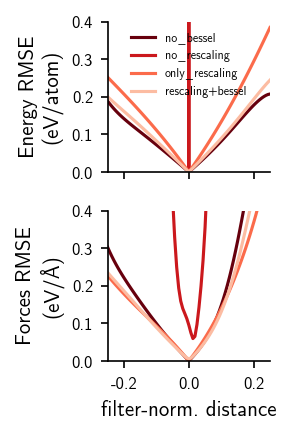

webf NOT subset; don't know how to subset; dropped


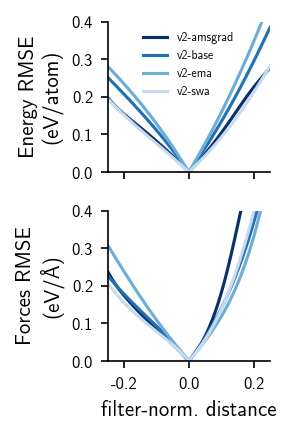

webf NOT subset; don't know how to subset; dropped


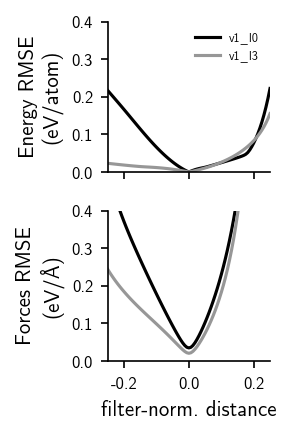

webf NOT subset; don't know how to subset; dropped


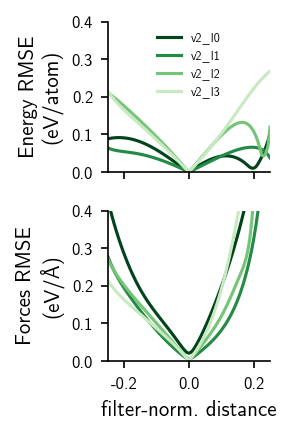

webf NOT subset; don't know how to subset; dropped


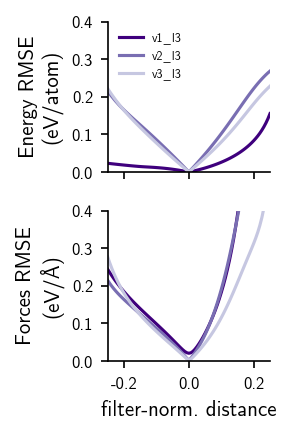

In [23]:
for name, grp in MODELS.items():
    _df = lls.loc[lls.model.isin(grp)].sort_values("model")
    _df = sort_df_by_category(_df, "model", grp)
    
    norm = plt.Normalize(0, len(grp))
    colors = [CMAPS[name](norm(i)) for i in range(len(grp))]
    
    fig, ax_fig = plt.subplots(2, 1, figsize=(2, 3), sharex=True)
    
    for color, (model, _subdf) in zip(colors, _df.groupby("model")):
        _subdf = _subdf.sort_values("x")
        
        for ax, qty in zip(ax_fig, ["e", "f"]):
            ax.plot(
                _subdf["x"],
                _subdf[qty],
                color=color,
                label=model,
            )
            ax.set_ylim(0.0, 0.4)
            ax.set_xlim(-0.25, 0.25)
    
    ax.set_xlabel("filter-norm. distance")
    ax_fig[0].set_ylabel("Energy RMSE\n(eV/atom)")
    ax_fig[1].set_ylabel("Forces RMSE\n(eV/Å)")
    
    ax_fig[0].legend(frameon=False, fontsize="xx-small")
    
    fig.tight_layout()
    fig.savefig(f"{FIGS_DIR}/mace_lls_{name}.pdf", bbox_inches="tight", transparent=True)
    
    plt.show()

## Error vs explosion

webf NOT subset; don't know how to subset; dropped


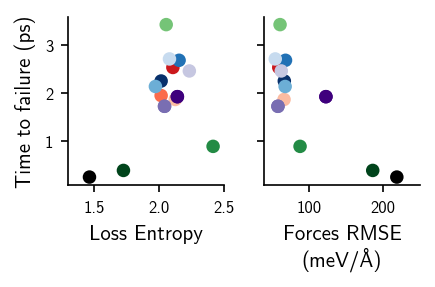

In [35]:
fig, ax_fig = plt.subplots(1, 2, figsize=(3, 2), sharey=True)

for name, grp in MODELS.items():
    _df = sdf.loc[grp]
    
    colors = labels.loc[_df.index]["color"]
    
    _y = _df["explosion_mean"] / 1000
    ax = ax_fig[0]
    ax.scatter(
        _df["S"],
        _y,
        c=colors,
        s=30,
    )
    ax.set_xlabel("Loss Entropy")
    ax.set_ylabel("Time to failure (ps)")
    ax.set_xlim(1.3, 2.5)
    
    ax = ax_fig[1]
    ax.scatter(
        _df["f"] * 1000,
        _y,
        c=colors,
        s=30,
    )
    ax.set_xlabel("Forces RMSE\n(meV/Å)")
    ax.set_xlim(40, 250)

fig.tight_layout()
fig.savefig(f"{FIGS_DIR}/mace_entropy_overview.pdf", bbox_inches="tight", transparent=True)
plt.show()

webf NOT subset; don't know how to subset; dropped


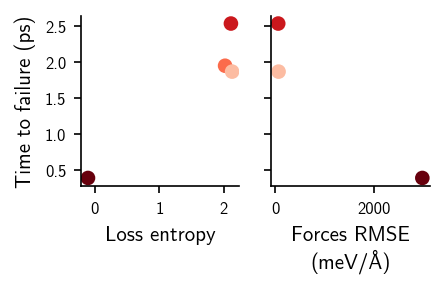

webf NOT subset; don't know how to subset; dropped


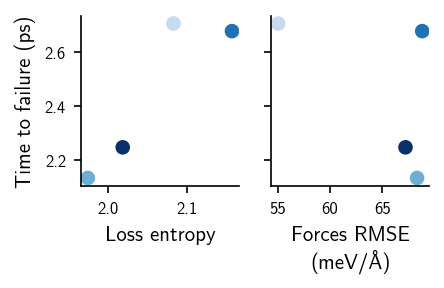

webf NOT subset; don't know how to subset; dropped


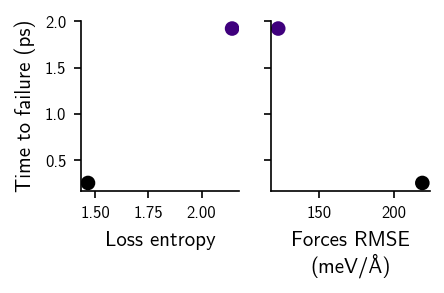

webf NOT subset; don't know how to subset; dropped


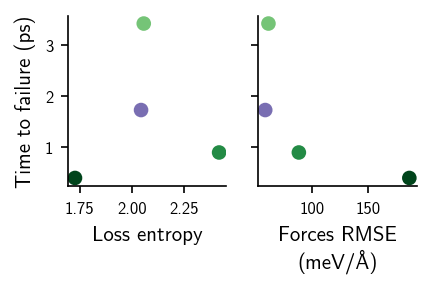

webf NOT subset; don't know how to subset; dropped


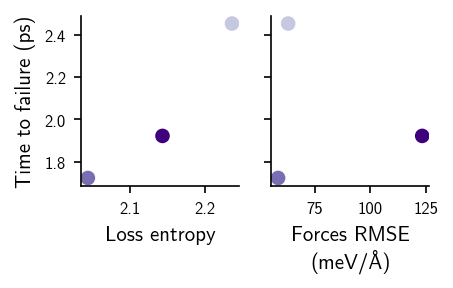

In [37]:
for name, grp in MODELS.items():
    _df = sdf.loc[grp]
    colors = labels.loc[_df.index]["color"]
    
    fig, ax_fig = plt.subplots(1, 2, figsize=(3, 1.5), sharey=True)
        
    ax = ax_fig[0]
    _y = _df["explosion_mean"] / 1000
    ax.scatter(
        _df["S"],
        _y,
        c=colors,
    )
    ax.set_xlabel("Loss entropy")
    ax.set_ylabel("Time to failure (ps)")
#     ax.set_xlim(1.3, 2.5)
    
    ax = ax_fig[1]
    ax.scatter(
        _df["f"] * 1000,
        _y,
        c=colors,
    )
    ax.set_xlabel("Forces RMSE\n(meV/Å)")    
    
    fig.savefig(f"{FIGS_DIR}/mace_entropy_{name}.pdf", bbox_inches="tight", transparent=True)
    plt.show()

webf NOT subset; don't know how to subset; dropped


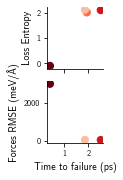

webf NOT subset; don't know how to subset; dropped


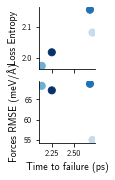

webf NOT subset; don't know how to subset; dropped


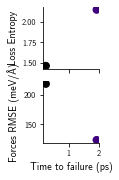

webf NOT subset; don't know how to subset; dropped


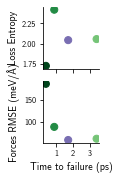

webf NOT subset; don't know how to subset; dropped


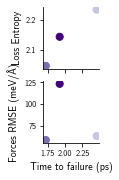

In [17]:
for name, grp in MODELS.items():
    _df = sdf.loc[grp]
    colors = labels.loc[_df.index]["color"]
    
    fig, ax_fig = plt.subplots(2, 1, figsize=(1, 2.5), sharex=True)
        
    ax = ax_fig[0]
    _x = _df["explosion_mean"] / 1000
    ax.scatter(
        _x,
        _df["S"],
        c=colors,
        s=50,
    )
    ax.set_ylabel("Loss Entropy")
#     ax.set_xlim(1.3, 2.5)
    
    ax = ax_fig[1]
    ax.scatter(
        _x,
        _df["f"] * 1000,
        c=colors,
        s=50,
    )
    ax.set_ylabel("Forces RMSE (meV/Å)") 
    ax.set_xlabel("Time to failure (ps)")
    
#     fig.tight_layout()
    fig.savefig(f"{FIGS_DIR}/mace_entropy_vert_{name}.pdf", bbox_inches="tight", transparent=True)
    plt.show()

## Slopes

In [38]:
slopes = lcv.pivot(index='model', columns="n", values="f")
slopes = slopes.drop(5, axis=1)
logslopes = np.log(slopes)

In [39]:
_slopes = {}

logn = np.log(logslopes.columns)

for model, row in logslopes.iterrows():    
    linregress = stats.linregress(logn, row.values)
    _slopes[model] = linregress.slope

slope_df = pd.DataFrame(_slopes.values(), index=_slopes.keys(), columns=["slopes"])

In [40]:
sdf2 = pd.concat([sdf, slope_df], axis=1).dropna()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
webf NOT subset; don't know how to subset; dropped


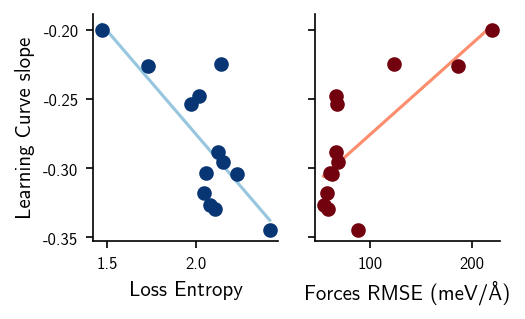

In [42]:
fig, ax_fig = plt.subplots(1, 2, figsize=(3.5, 2), sharey=True)

_df = sdf2.loc[sdf2["S"] > 0]

ax = ax_fig[0]
_x = _df["S"]
_y = _df["slopes"]

ax.scatter(_x, _y, c=cm.Blues(250))

ax.set_ylabel("Learning Curve slope")
ax.set_xlabel("Loss Entropy")

reg = stats.linregress(_x, _y)
newx = np.linspace(_x.min(), _x.max(), 3)
newy = reg.slope * newx + reg.intercept

ax.plot(newx, newy, zorder=-1, color=cm.Blues(100))


ax = ax_fig[1]
_x = _df["f"] * 1e3
_y = _df["slopes"]

ax.scatter(_x, _y, c=cm.Reds(250))

# ax.set_ylabel("Learning Curve slope")
ax.set_xlabel("Forces RMSE (meV/Å)")

reg = stats.linregress(_x, _y)
newx = np.linspace(_x.min(), _x.max(), 3)
newy = reg.slope * newx + reg.intercept

ax.plot(newx, newy, zorder=-1, color=cm.Reds(100))

fig.savefig(f"{FIGS_DIR}/mace_slopes.pdf", bbox_inches="tight", transparent=True)
plt.show()

## Showing that errors at 300 K do not help

In [43]:
ext2 = (ext
    .groupby(["nsamples", "label"])
    .first()
    .reset_index()
    .pivot(columns="nsamples", values="test_300K_forces", index="label")
)
ext2 = pd.concat([
    ext2,
    sdf["f"],
], axis=1)

ext2 = ext2.loc[~ext2[500].isna()]

webf NOT subset; don't know how to subset; dropped


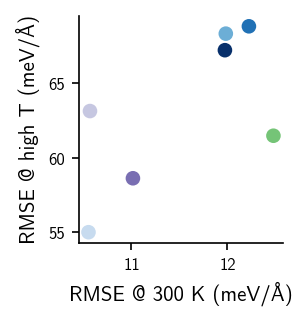

In [47]:
_df = ext2.loc[ext2[500] < 0.015]
_x = _df[500] * 1000
_y = _df["f"] * 1000
_c = labels.loc[_df.index]["color"]

fig, ax = plt.subplots(figsize=(1.75, 2))

ax.scatter(_x, _y, c=_c)
ax.set_xlabel("RMSE @ 300 K (meV/Å)")
ax.set_ylabel("RMSE @ high T (meV/Å)")

fig.savefig(f"{FIGS_DIR}/mace_RMSE_temperatures.pdf", bbox_inches="tight", transparent=True)

plt.show()

webf NOT subset; don't know how to subset; dropped


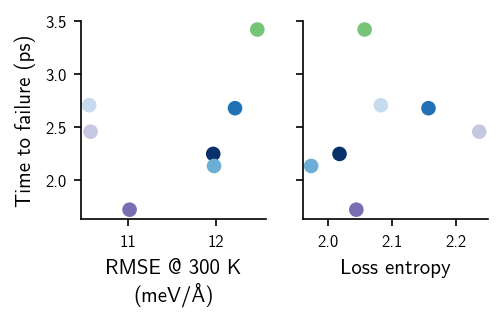

In [49]:
fig, ax_fig = plt.subplots(1, 2, figsize=(3.5, 1.75), sharey=True)

_df = ext2.loc[ext2[500] < 0.015]

ax = ax_fig[0]
_x = _df[500] * 1000
_y = sdf.loc[_x.index, "explosion_mean"] / 1000
_c = labels.loc[_x.index]["color"]

ax.scatter(_x, _y, c=_c)
ax.set_xlabel("RMSE @ 300 K\n(meV/Å)")
ax.set_ylabel("Time to failure (ps)")

ax = ax_fig[1]
_x = sdf.loc[_df.index, "S"]
_y = sdf.loc[_x.index, "explosion_mean"] / 1000
_c = labels.loc[_x.index]["color"]

ax.scatter(_x, _y, c=_c)
ax.set_xlabel("Loss entropy")
# ax.set_ylabel("Time to failure (ps)")

fig.savefig(f"{FIGS_DIR}/mace_lowRMSE_trends.pdf", bbox_inches="tight", transparent=True)
plt.show()